### In this notebook I attempt to fit my data using an AWD-LSTM neural network with the fastai library.

In [1]:
# Handle imports

import pandas as pd
import numpy as np
import csv  

from sklearn.model_selection import train_test_split
import random
from datetime import datetime

from fastai.text import *

#Load the data
file_path_comments = "../Data/cleaned_comment_data_50k.csv"

clean_comments = pd.read_csv(file_path_comments, index_col = False)

In [2]:
X = clean_comments['commentBody']
y = clean_comments['recommendations']
print(X[1])
y.head(5)

Stunning photos and reportage. Infuriating that the Trump admistration's draconian reinstatement of the global gag order will prevent men and women from receiving appropriate family planning advice, so obviously desperately   needed.


0    2.0
1    1.0
2    3.0
3    7.0
4    5.0
Name: recommendations, dtype: float64

In [3]:
len(clean_comments)

50000

##### In this next cell, I convert my integer target, 'recommendations', to a category target. I create bins such that comments with 0 recommendations are in bin 0 and all other comments are in bin 1.

In [4]:
#set up bins
bin = [-1, 1, float('inf')]
label = [0, 1]
#use pd.cut function can attribute the values into its specific bins
category = pd.cut(y, bin, right = False, labels=label)
category = category.to_frame()
category.columns = ['range']
#concatenate age and its bin
df_new = pd.concat([y,category],axis = 1)
df_new['comment'] = X

In [5]:
df_new.head(5)

,recommendations,range,comment
0,2.0,1,This project makes me happy to be a 30+ year T...
1,1.0,1,Stunning photos and reportage. Infuriating tha...
2,3.0,1,Brilliant work from conception to execution. I...
3,7.0,1,NYT reporters should provide a contributor's l...
4,5.0,1,Could only have been done in print. Stunning.


In [6]:
# Here I create a 'balanced' dataset to see if this improves my model accuracy.

df_0 = df_new.loc[df_new['range'] == 0]
df_1 = df_new.loc[df_new['range'] == 1]

print(len(df_0), len(df_1))

df_balanced = pd.concat([df_0[:(len(df_0)-1)], df_1[:(len(df_0)-1)]], axis=0)

df_balanced.head(5)

13159 36841


,recommendations,range,comment
8,0.0,0,I agree. I've just spent 30 minutes trying to ...
71,0.0,0,I don't know about Paul Ryan and if we can bla...
124,0.0,0,Would be interesting to know how much taxpayer...
126,0.0,0,"This is a funny column. But seriously folks, ..."
131,0.0,0,The only benefit to Trump's presidency and a R...


##### Here I create a crossfold validation split. I then merge the separated comments and recommendation counts into one dataframe containing training data and one dataframe containing test data, which fastai takes as inputs.

In [7]:
#Here I'm using the imbalanced dataset

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced['comment'], df_balanced['range'], test_size=0.2, random_state=random.seed(datetime.now()))

##### In this cell I am creating my model using data blocks created using the text classifier with the LSTM model architecture.

In [10]:
df_nlp_data_train = pd.concat([y_train, X_train], axis=1)
df_nlp_data_test = pd.concat([y_test, X_test], axis=1)

path = '../Data/'
data_lm = TextLMDataBunch.from_df(path="", train_df=df_nlp_data_train, valid_df=df_nlp_data_test, bs=32)
data_clas  = TextClasDataBunch.from_df(path="", train_df=df_nlp_data_train, valid_df=df_nlp_data_test, bs=32)

In [11]:
#First I train my encoder on my word corpus. This model comes with a pretrained AWD_LSTM architecture using transfer learning.

learn = language_model_learner(data_lm, AWD_LSTM)
learn.metrics=[accuracy]
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-2), moms=(0.8,0.7))

# I save my encoder
learn.save_encoder('enc')

epoch,train_loss,valid_loss,accuracy,time
0,3.955914,3.711527,0.355575,01:59


In [12]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.3)
learn.load_encoder('enc')

# Avoid massive text dump

print("Complete!")

Complete!


In [13]:
#Here I want to find what learning rate to use for my model.

learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-02
Min loss divided by 10: 3.98E-03


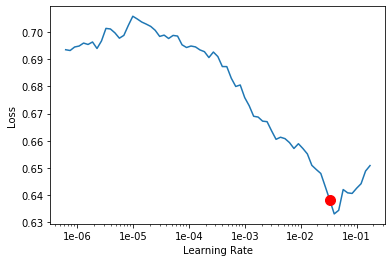

In [14]:
# Set the learning rate to the point with the minimum gradient

learn.recorder.plot(suggestion=True, skip_end=15)
min_grad_lr=learn.recorder.min_grad_lr

In [15]:
# Train my model for one cycle. Loss tends to increase with additional epochs - one cycle is sufficient.

learn.fit_one_cycle(1, min_grad_lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.592676,0.564728,0.681801,01:18


In [16]:
# Save the model
learn.save('balanced_50k_test')
learn.export('models/balanced_50k.pkl')

In [17]:
learn.load('balanced_50k_test')

# Avoid massive text dump

print("Load complete!")

Load complete!


##### Here we get the predictions of the validation set, then print a sample of predictions. This is to verify that the model is not defaulting to a trivial output such as putting all predictions in the same category.

In [18]:
preds, y_predict, loss = learn.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y_predict)
print('The accuracy is {0} %.'.format(acc))


#balanced: .70, imbalanced: .78
#The unbalanced model has higher accuracy

The accuracy is 0.681800901889801 %.


In [19]:
# Now let's analyze the predictions on the test data

predCat = preds.data.numpy().argmax(axis=1)

print(len(preds))
print(len(y_predict))

5264
5264


In [20]:
# Get the F! score, the precision and the recall

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print('F1:        {}'.format(f1_score(y_predict, predCat)))
print('Precision: {}'.format(precision_score(y_predict, predCat)))
print('Recall:    {}'.format(recall_score(y_predict, predCat)))

# Balanced: 0.74, .68, .79
# Unbalanced: .87, .78, .99

# The unbalanced model has higher precision, recall and F1

F1:        0.7293585393439975
Precision: 0.6350590883511537
Recall:    0.8565464895635674


Text(0.5, 1.0, 'Predictions')

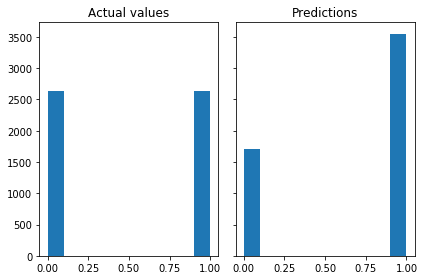

In [21]:
# Plot my predicted values to look for overfitting

n_bins=10

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(y_test[:10000], bins=n_bins)
#axs[0].set_yscale('log')
axs[0].set_title('Actual values')
axs[1].hist(predCat[:10000], bins=n_bins)
#axs[1].set_yscale('log')
axs[1].set_title('Predictions')

In [22]:
# Here I split out my predictions so I can create a confusion matrix

act_vs_pred = pd.concat([pd.DataFrame(y_predict.numpy()), pd.Series(predCat[:10000])], axis=1, ignore_index=True)

act_vs_pred.columns = (['actual', 'predict'])
print(act_vs_pred.head(5))

print(act_vs_pred['actual'].value_counts())
print(act_vs_pred['predict'].value_counts())

act_vs_pred.to_csv('act_vs_pred.csv', index=False)

pd.crosstab(act_vs_pred['actual'], act_vs_pred['predict'])

   actual  predict
0       0        0
1       0        1
2       1        1
3       0        0
4       0        1
1    2635
0    2629
Name: actual, dtype: int64
1    3554
0    1710
Name: predict, dtype: int64


predict,0,1
actual,,
0,1332,1297
1,378,2257


##### The balanced model has a -much- lower false positive rate than the imbalanced model. Use this one!